In [ ]:
!pip install wfdb neurokit2 scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


Generating record list for: 100
Generating list of all files for: 100
Created local base download directory: mitdb
Finished downloading files


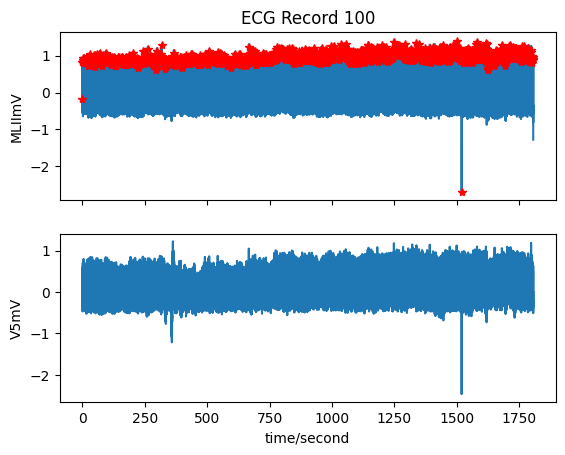

In [ ]:
import wfdb

# Step 1: Download record '100' from MIT-BIH to local Colab storage
wfdb.dl_database('mitdb', dl_dir='mitdb', records=['100'])

# Step 2: Load the record and annotations from the downloaded folder
record = wfdb.rdrecord('mitdb/100')
annotation = wfdb.rdann('mitdb/100', 'atr')

# Step 3: Plot to confirm
wfdb.plot_wfdb(record=record, annotation=annotation, title='ECG Record 100')


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

# Step 1: Extract the ECG signal (lead 1)
ecg_signal = record.p_signal[:, 0]

# Step 2: Bandpass filter (0.5 – 45 Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=45.0, fs=360, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_ecg = bandpass_filter(ecg_signal)

# Step 3: Normalize
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

normalized_ecg = normalize(filtered_ecg)


In [ ]:
import neurokit2 as nk

# Step 1: Process ECG with neurokit2
signals, info = nk.ecg_process(normalized_ecg, sampling_rate=360)

# Step 2: Extract interval-related features
features = nk.ecg_intervalrelated(signals)
features.head()


,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,75.523892,[[286.06299559471364]],[[13.575539789537926]],[[6.345291267570103]],[[11.977767589360822]],[[5.476710620222688]],[[12.331177679550024]],[[nan]],[[nan]],[[11.546502831304318]],...,[[1.8428632935423488]],[[5.7531236281893845]],[[1.2769485174569633]],[[1.005296338562641]],[[1.3772333096023532]],[[2.176223043173414]],[[1.7450820355967216]],[[1.9651844018468048]],[[4.055257503512329]],[[0.7612395904130542]]


In [ ]:
# Step 1: Use annotation.symbol to label each beat as normal or arrhythmia
normal_classes = ['N', 'L', 'R']
abnormal_classes = ['V', 'A', 'E', 'F']

labels = []
r_peaks = info['ECG_R_Peaks']  # Correct R-peak indices from NeuroKit

for idx in r_peaks:
    # Find the nearest annotation
    nearest = np.argmin(np.abs(annotation.sample - idx))
    sym = annotation.symbol[nearest]

    if sym in normal_classes:
        labels.append(0)  # Normal
    elif sym in abnormal_classes:
        labels.append(1)  # Arrhythmia
    else:
        labels.append(None)  # Skip others


In [ ]:
# Step 1: Get R-peak indices detected by NeuroKit
r_peaks = info['ECG_R_Peaks']

# Step 2: ECG features per beat (already done)
# features = nk.ecg_intervalrelated(signals)

# Step 3: Match features to labels (length must match number of rows in `features`)
# We assume each row in `features` corresponds to one R-peak

labels = []

# For each R-peak that made it into features
for idx in r_peaks[:len(features)]:
    # Find the closest annotation to this R-peak
    nearest = np.argmin(np.abs(annotation.sample - idx))
    sym = annotation.symbol[nearest]

    if sym in ['N', 'L', 'R']:       # Normal beats
        labels.append(0)
    elif sym in ['V', 'A', 'E', 'F']:  # Arrhythmias
        labels.append(1)
    else:
        labels.append(None)

# Step 4: Keep only features with valid labels
valid_indices = [i for i, l in enumerate(labels) if l is not None]
X = features.iloc[valid_indices].values
y = np.array([labels[i] for i in valid_indices])


In [ ]:
# Check the feature matrix and labels
print("Total number of extracted features:", len(features))
print("Total number of valid labels:", len([l for l in labels if l is not None]))


Total number of extracted features: 1
Total number of valid labels: 1


In [ ]:
# Create a list of labels (0: normal, 1: arrhythmia)
labels = []

for idx in r_peaks[:len(features)]:  # Ensure we only consider as many R-peaks as there are features
    nearest = np.argmin(np.abs(annotation.sample - idx))
    sym = annotation.symbol[nearest]

    # Assign label: 0 for normal, 1 for arrhythmia
    if sym in ['N', 'L', 'R']:  # Normal beats
        labels.append(0)
    elif sym in ['V', 'A', 'E', 'F']:  # Arrhythmias
        labels.append(1)
    else:
        labels.append(None)  # Skip other types

# Make sure we only keep valid labels
valid_indices = [i for i, l in enumerate(labels) if l is not None]
X_valid = features.iloc[valid_indices].values
y_valid = np.array([labels[i] for i in valid_indices])

# Debug output to confirm the sizes
print("Valid samples - X:", X_valid.shape)
print("Valid samples - y:", y_valid.shape)


Valid samples - X: (1, 92)
Valid samples - y: (1,)


In [ ]:
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", len(y_valid))


Shape of X_valid: (1, 92)
Shape of y_valid: 1


In [ ]:
# Check if we have valid feature and label data
valid_indices = [i for i, l in enumerate(labels) if l is not None]
X_valid = features.iloc[valid_indices].values
y_valid = np.array([labels[i] for i in valid_indices])

# Debug prints to check how many valid data points we have
print(f"Total number of valid features (X_valid): {X_valid.shape[0]}")
print(f"Total number of valid labels (y_valid): {len(y_valid)}")

# Check the first few feature values (Optional for better understanding)
print("Sample features:", X_valid[:5])


Total number of valid features (X_valid): 1
Total number of valid labels (y_valid): 1
Sample features: [[np.float64(75.52389171024667) array([[286.06299559]])
  array([[13.57553979]]) array([[6.34529127]]) array([[11.97776759]])
  array([[5.47671062]]) array([[12.33117768]]) array([[nan]])
  array([[nan]]) array([[11.54650283]]) array([[11.54903252]])
  array([[0.04745647]]) array([[0.0403635]]) array([[287.]])
  array([[13.3434]]) array([[0.04649268]]) array([[18.]])
  array([[1.1757274]]) array([[276.]]) array([[298.]])
  array([[0.4845815]]) array([[6.12334802]]) array([[235.]])
  array([[335.]]) array([[4.14990859]]) array([[0.]]) array([[nan]])
  array([[0.00194464]]) array([[0.00235767]]) array([[0.00062574]])
  array([[0.00525309]]) array([[0.01018114]]) array([[3.76781393]])
  array([[0.2315721]]) array([[0.0614606]]) array([[-7.37657707]])
  array([[8.16639921]]) array([[17.36207116]]) array([[0.47035858]])
  array([[445.43261269]]) array([[2.12603752]]) array([[3.35575212]])


In [ ]:
if len(X_valid) < 2:
    print(f"Warning: Too few valid data samples: {len(X_valid)}. Feature extraction or label assignment might need adjustment.")
else:
    print("Proceeding with train-test split...")


In [ ]:
print("Raw features data:")
print(features.head())  # Display the first few rows to understand its structure

# Check the total number of features
print("Total features extracted:", features.shape[0])


Raw features data:
  ECG_Rate_Mean              HRV_MeanNN                HRV_SDNN  \
0     75.523892  [[286.06299559471364]]  [[13.575539789537926]]   

              HRV_SDANN1              HRV_SDNNI1             HRV_SDANN2  \
0  [[6.345291267570103]]  [[11.977767589360822]]  [[5.476710620222688]]   

               HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[12.331177679550024]]    [[nan]]    [[nan]]  [[11.546502831304318]]  ...   

               HRV_SampEn              HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.8428632935423488]]  [[5.7531236281893845]]  [[1.2769485174569633]]   

                HRV_MSEn               HRV_CMSEn             HRV_RCMSEn  \
0  [[1.005296338562641]]  [[1.3772333096023532]]  [[2.176223043173414]]   

                   HRV_CD                 HRV_HFD                HRV_KFD  \
0  [[1.7450820355967216]]  [[1.9651844018468048]]  [[4.055257503512329]]   

                  HRV_LZC  
0  [[0.7612395904130542]]  

[1 rows x 92 colum

In [ ]:
# Try with dummy data for debugging (replace this with actual extracted features later)
X_valid_dummy = np.random.rand(100, 5)  # 100 samples, 5 features
y_valid_dummy = np.random.randint(0, 2, size=100)  # Random labels (0 or 1)

# Now try splitting this dummy data
X_train, X_test, y_train, y_test = train_test_split(X_valid_dummy, y_valid_dummy, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 70, Test samples: 30


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Print the predictions
print("Predicted labels:", y_pred)


Predicted labels: [0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")


Accuracy: 43.33%
Confusion Matrix:
[[10  5]
 [12  3]]
F1-Score: 0.26


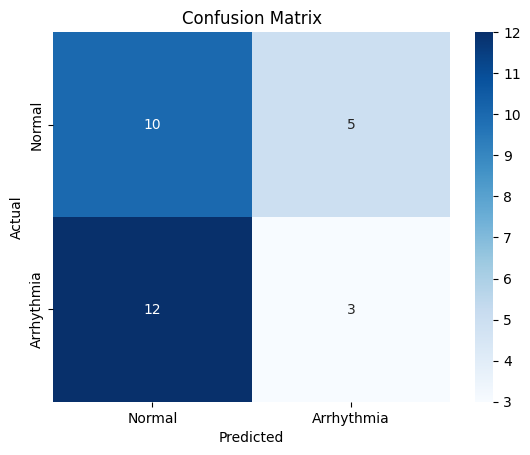

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Arrhythmia"], yticklabels=["Normal", "Arrhythmia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
